# Investigating Misclassifications (cont...)

In [1]:
import os
os.chdir('C:\Users\Lundi\Documents\Programming\Python\Kaggle\Digits')
#os.chdir('/Users/alexsutherland/Documents/Programming/Python/Kaggle/Digits')
import time

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.svm as skl_svm
import sklearn.cross_validation as skl_cv
from sklearn.grid_search import GridSearchCV

## Classification probabilites

First, I need to load the data:

In [2]:
digit_data = pd.read_csv('Data/train.csv')

X = digit_data.ix[:,1:digit_data.shape[1]]
y = digit_data['label']

Next, I will generate a prediction for each element in a subset of the full data. Furthermore, I need the prediction probabilities for these same samples. Therefore, I will run a custom cross-validation to get both of these:

In [4]:
col_names = ['Actual','Predicted']
col_names.extend(map(lambda x: str(x), xrange(10)))

y_result_df = pd.DataFrame({'Actual': y.copy(), 'Predicted': -1}, columns=col_names)
y_result_df.head()

,Actual,Predicted,0,1,2,3,4,5,6,7,8,9
0,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
start_time = time.time()
svc_poly_clf = skl_svm.SVC(
    C=2.8e-5, 
    degree=2, 
    gamma='auto', 
    kernel='poly', 
    tol=0.001,
    probability=True
)

for train_indexes, test_indexes in skl_cv.KFold(n = X.shape[0], n_folds=5):
    X_train = X.ix[train_indexes, :]
    X_test = X.ix[test_indexes, :]
    y_train = y.ix[train_indexes]
    y_test = y.ix[test_indexes]
    
    svc_poly_clf.fit(X_train, y_train)
    y_result_df.ix[X_test.index, 'Predicted'] = svc_poly_clf.predict(X_test)
    y_result_df.ix[X_test.index, map(lambda x: str(x), xrange(10))] = svc_poly_clf.predict_proba(X_test)
    
print 'Elapsed time: ', ((time.time() - start_time) / 3600.0), 'hours'

Elapsed time:  0.743495277762 hours


In [6]:
y_result_df.head()

,Actual,Predicted,0,1,2,3,4,5,6,7,8,9
0,1,1,5.25626e-05,0.994604,0.000676433,7.21474e-05,0.000158113,4.00525e-05,0.000170103,9.84236e-05,0.00409917,2.90998e-05
1,0,0,1,1.2318e-08,4.2633e-08,1.98732e-08,1.2212e-08,2.50816e-08,5.22353e-08,1.59762e-08,1.71401e-08,1.01896e-07
2,1,1,2.82456e-08,0.999483,1.90311e-05,4.4817e-06,5.22244e-06,1.06001e-06,1.81068e-06,0.000330304,0.000151161,3.54407e-06
3,4,4,0.0195235,0.0118386,0.0480015,0.015212,0.5815,0.0509052,0.0804627,0.0629277,0.0147919,0.114837
4,0,0,1,1.23162e-08,4.38214e-08,1.96466e-08,1.2204e-08,2.52233e-08,5.34084e-08,1.45262e-08,1.97309e-08,1.04577e-07


Next, I will make a DataFrame with the actual and predictive classes, along with a column for if the prediction was correct:

In [7]:
y_result_df['is_correct'] = -1
y_result_df['is_correct'] = y_result_df.apply(lambda row: row['Actual'] == row['Predicted'],axis=1)
y_result_df.head(2)

,Actual,Predicted,0,1,2,3,4,5,6,7,8,9,is_correct
0,1,1,5.25626e-05,0.994604,0.000676433,7.21474e-05,0.000158113,4.00525e-05,0.000170103,9.84236e-05,0.00409917,2.90998e-05,True
1,0,0,1,1.2318e-08,4.2633e-08,1.98732e-08,1.2212e-08,2.50816e-08,5.22353e-08,1.59762e-08,1.71401e-08,1.01896e-07,True


Let's write this to disk:

In [8]:
y_result_df.to_csv('Data/svc_classification_data.csv')

I will now limit this to only rows that were actually 8:

In [9]:
y_result_8s_df = y_result_df.ix[y_result_df['Actual'] == 8,:].drop(['Actual'], axis=1)
y_result_8s_df.head(2)

,Predicted,0,1,2,3,4,5,6,7,8,9,is_correct
10,8,1.28596e-10,8.51211e-11,1.03847e-10,2.99312e-10,1.23264e-10,3.27097e-10,6.71235e-11,1.28263e-10,1,2.05909e-07,True
20,8,6.65271e-05,2.89065e-05,0.000128953,0.00319014,1.32308e-05,0.000223924,5.09302e-06,9.39623e-06,0.992407,0.00392731,True


Converting everything to numeric

In [10]:
y_result_8s_df[['0','1','2','3','4','5','6','7','8','9']] = y_result_8s_df[['0','1','2','3','4','5','6','7','8','9']].apply(lambda c: pd.to_numeric(c), axis=0)

Now let's do some analysis based on if the actual 8 was classified correctly or not:

In [11]:
y_result_8s_grouped_describe = y_result_8s_df.groupby(['is_correct'])[['0','1','2','3','4','5','6','7','8','9']].describe()
y_result_8s_grouped_describe.applymap(lambda x: round(x,3))

0         1         2         3         4         5  \
is_correct                                                                     
False      count   142.000   142.000   142.000   142.000   142.000   142.000   
           mean      0.058     0.091     0.083     0.164     0.047     0.115   
           std       0.163     0.234     0.168     0.267     0.122     0.214   
           min       0.000     0.000     0.000     0.000     0.000     0.000   
           25%       0.001     0.001     0.003     0.006     0.001     0.003   
           50%       0.006     0.006     0.016     0.032     0.006     0.020   
           75%       0.022     0.022     0.068     0.171     0.021     0.081   
           max       0.903     0.990     0.963     0.999     0.830     0.940   
True       count  3921.000  3921.000  3921.000  3921.000  3921.000  3921.000   
           mean      0.001     0.002     0.004     0.008     0.002     0.005   
           std       0.011     0.016     0.022     0.029     0.011     0.025   
           min       0.000     0.000     0.000     0.000     0.000     0.000   
           25%       0.000     0.000     0.000     0.000     0.000     0.000   
           50%       0.000     0.000     0.000     0.000     0.000     0.000   
           75%       0.000     0.000     0.001     0.002     0.000     0.000   
           max       0.381     0.411     0.457     0.513     0.303     0.407   

                         6         7         8         9  
is_correct                                                
False      count   142.000   142.000   142.000   142.000  
           mean      0.062     0.045     0.222     0.112  
           std       0.157     0.137     0.153     0.231  
           min       0.000     0.000     0.001     0.000  
           25%       0.001     0.001     0.087     0.002  
           50%       0.006     0.006     0.222     0.014  
           75%       0.032     0.019     0.340     0.052  
           max       0.886     0.995     0.594     0.977  
True       count  3921.000  3921.000  3921.000  3921.000  
           mean      0.002     0.002     0.969     0.005  
           std       0.014     0.013     0.086     0.023  
           min       0.000     0.000     0.200     0.000  
           25%       0.000     0.000     0.988     0.000  
           50%       0.000     0.000     0.999     0.000  
           75%       0.000     0.000     1.000     0.001  
           max       0.412     0.333     1.000     0.395

## Plotting differences between correct and incorrect prediction probabilities

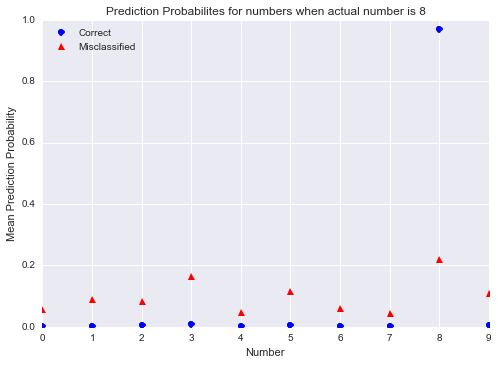

In [12]:
plt.plot(xrange(10), y_result_8s_grouped_describe.ix[(True,'mean')], 'bo')
plt.plot(xrange(10), y_result_8s_grouped_describe.ix[(False,'mean')], 'r^')
plt.legend(['Correct', 'Misclassified'], loc='upper left')
ax = plt.gca()
ax.set_xlabel('Number')
ax.set_ylabel('Mean Prediction Probability')
ax.set_title('Prediction Probabilites for numbers when actual number is 8')

## Plotting distribution of prediction probs of 8 for correct and misclassified

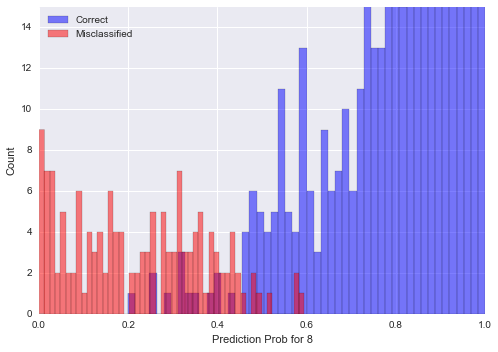

In [17]:
plt.hist(y_result_8s_df.ix[y_result_8s_df['is_correct'],'8'].values, bins=50, alpha=0.5, color='b');
plt.hist(y_result_8s_df.ix[~y_result_8s_df['is_correct'],'8'].values, bins=50, alpha=0.5, color='r');
ax = plt.gca();
ax.set_ylim([0,15]);
ax.set_xlabel('Prediction Prob for 8')
ax.set_ylabel('Count')
ax.legend(['Correct','Misclassified'], loc='upper left')

This shows that a cut-off near a prediction probability of ~0.4 will capture most of the incorrectly classified 8s. The remainder can undergo further analysis

## Predicting with prediction probabilities

Given the prediction probabilities, can I generate an AdaBoost tree model that will improve the prediction accuracy?

First, let's calculate the current CV accuracy:

In [21]:
np.mean(map(lambda prediction: 1 if prediction else 0, y_result_df['is_correct']))

0.9759523809523809

### Generating design matrix with prediction probabilities

In [29]:
X_pp = y_result_df.drop(['is_correct','Actual','Predicted'], axis=1)
y_pp = y_result_df['Actual']

X_pp_train, X_pp_test, y_pp_train, y_pp_test = skl_cv.train_test_split(X_pp, y_pp, test_size = 0.2)

In [26]:
import sklearn.ensemble as skl_ensemble
import sklearn.tree as skl_tree

dt_stump_clf = skl_tree.DecisionTreeClassifier(max_depth=1)
dt_clf = skl_tree.DecisionTreeClassifier()

#### Base Estimator accuracy

In [27]:
accuracy_dt_stump = np.mean(skl_cv.cross_val_score(dt_stump_clf, X_pp, y_pp, cv=5))

#### AdaBoost Stump Model

In [ ]:
ada_dt_stump_clf = skl_ensemble.AdaBoostClassifier(
    base_estimator=dt_stump_clf,
    n_estimators=5000,
    learning_rate=0.1
)
ada_dt_stump_clf.fit(X_pp_train, y_pp_train)

ada_dt_stump_staged_accuracies = []
for index, y_pred in enumerate(ada_dt_stump_clf.staged_predict(X_pp_test)):
    current_accuracy = np.mean(y_pred == y_pp_test)
    ada_dt_stump_staged_accuracies.append([index, current_accuracy])
    ada_dt_stump_clf

ada_dt_stump_staged_accuracies = pd.DataFrame(ada_dt_stump_staged_accuracies, columns=['Stage', 'Accuracy'])

Plotting the staged accuracy of the DT stump

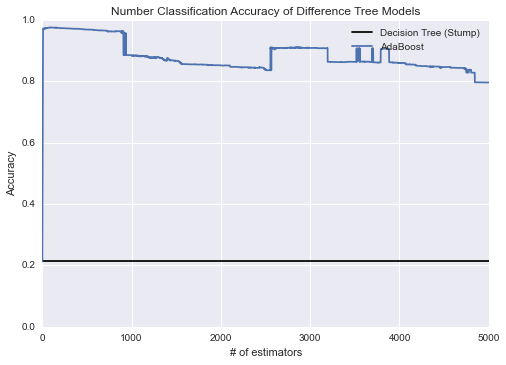

In [33]:
plt.axhline(accuracy_dt_stump, color='black')
plt.plot(ada_dt_stump_staged_accuracies['Stage'], ada_dt_stump_staged_accuracies['Accuracy'])
ax = plt.gca()
ax.set_ylim([0,1])
ax.legend(['Decision Tree (Stump)', 'AdaBoost'])
ax.set_xlabel('# of estimators')
ax.set_ylabel('Accuracy')
ax.set_title('Number Classification Accuracy of Difference Tree Models')    

#### AdaBoost DT Model

In [35]:
ada_dt_clf = skl_ensemble.AdaBoostClassifier(
    base_estimator=dt_clf,
    learning_rate=0.1,
    n_estimators=5000)
ada_dt_clf.fit(X_pp_train, y_pp_train)

ada_dt_staged_accuracies = []
for index, y_pred in enumerate(ada_dt_clf.staged_predict(X_pp_test)):
    current_accuracy = np.mean(y_pred == y_pp_test)
    ada_dt_staged_accuracies.append([index, current_accuracy])

ada_dt_staged_accuracies = pd.DataFrame(ada_dt_staged_accuracies, columns=['Stage', 'Accuracy'])

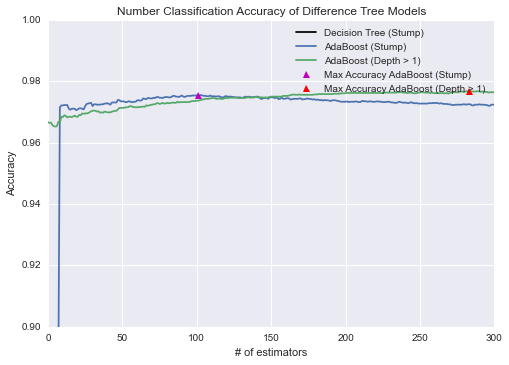

In [39]:
plt.axhline(accuracy_dt_stump, color='black')
plt.plot(ada_dt_stump_staged_accuracies['Stage'], ada_dt_stump_staged_accuracies['Accuracy'])
plt.plot(ada_dt_staged_accuracies['Stage'], ada_dt_staged_accuracies['Accuracy'])

plt.plot(ada_dt_stump_staged_accuracies['Accuracy'].idxmax(), ada_dt_stump_staged_accuracies['Accuracy'].max(), marker='^', c='m', linestyle='None')
plt.plot(ada_dt_staged_accuracies['Accuracy'].idxmax(), ada_dt_staged_accuracies['Accuracy'].max(), marker='^', c='r', linestyle='None')
ax = plt.gca()
ax.set_xlim([0,300])
ax.set_ylim([0.9,1])
ax.legend(['Decision Tree (Stump)', 'AdaBoost (Stump)','AdaBoost (Depth > 1)','Max Accuracy AdaBoost (Stump)','Max Accuracy AdaBoost (Depth > 1)'])
ax.set_xlabel('# of estimators')
ax.set_ylabel('Accuracy')
ax.set_title('Number Classification Accuracy of Difference Tree Models')    

In [44]:
ada_dt_stump_staged_accuracies.ix[ada_dt_stump_staged_accuracies['Accuracy'].idxmax(),:]

Stage       101.000000
Accuracy      0.975476
Name: 101, dtype: float64

#### SVC on prediction probs

In [59]:
svc_poly_clf = skl_svm.SVC(
    degree=2, 
    gamma='auto', 
    kernel='poly', 
    tol=0.001,
    cache_size=2000
)
svc_poly_clf.fit(X_pp.ix[0:4000,:], y_pp.ix[0:4000])
svc_poly_clf.predict(X_pp.ix[4001:8000,:])

#skl_cv.cross_val_score(svc_poly_clf, X_pp, y_pp, cv=5)

array([8, 0, 5, ..., 2, 3, 8], dtype=int64)

Watch out: the C value prevented this from making good predictions

#### SVC with AdaBoost (currently too compuatationally intenstive)

In [42]:
ada_svc_clf = skl_ensemble.AdaBoostClassifier(
    base_estimator=svc_poly_clf,
    learning_rate=0.1,
    n_estimators=30)
ada_svc_clf.fit(X_pp_train, y_pp_train)

ada_svc_staged_accuracies = []
for index, y_pred in enumerate(ada_svc_clf.staged_predict(X_pp_test)):
    current_accuracy = np.mean(y_pred == y_pp_test)
    ada_svc_staged_accuracies.append([index, current_accuracy])

ada_svc_staged_accuracies = pd.DataFrame(ada_svc_staged_accuracies, columns=['Stage', 'Accuracy'])

KeyboardInterrupt: 